# Change Point Detection algorithms

Even Matencio - 17/04/2024

## Standard time series

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import time
from timeit import timeit

from custom_cost_functions import MyL2Cost

### Some cost functions

In [4]:
def dummy_L2(signal):
    '''Returns the L2 cost of approximation by mean of the possibly multivariate input signal.

    Args: 
        signal (np.ndarray): of shape [n_samples, n_dim]
    '''
    return np.sum(np.var(signal, axis=0))*signal.shape[0]

### Search methods implementation

In [5]:
def naive_opt_cpd_dynprog(signal, cost_func, pen_val):
    ''' A naive version of the optimal partitioning algorithm described in 'Optimal Detection
    of Changepoints With a Linear Computational Cost, R. Killick' witout prunning and 
    per segment cost pre-computation. 
    
    DISCLAIMER: too expensive memory speaking, it is very frequently not possible
    to store [n_samples, n_samples] matrices.

    Args:
        signal (np.ndarray): of shape [n_samples, n_dim]
        cost_func func([np.ndarray], float): computes the approximation cost of the input sub-signal
        pen_val (float): penalty coefficient

    return:
        cps_per_t[-1] (List[int]): change points detected
        tot_costs[-1] (float): associated overall cost
    '''
    # Initialization
    n_samples = signal.shape[0]
    tot_costs = -pen_val * np.ones(n_samples+1)
    cps_per_t = [[]]
    # Dynamic programmation CPD without segment cost pre-computation
    for t in range(1, n_samples+1):
        # Compute all possible costs
        running_per_segment_cost = np.array(list(map(cost_func, [signal[s:t, :] for s in range(0, t)])))
        possible_running_costs =  tot_costs[:t] + running_per_segment_cost + pen_val
        # Extract the change-point (argmin) and store it
        cp = np.argmin(possible_running_costs)
        tot_costs[t] = possible_running_costs[cp]
        cps_per_t.append(cps_per_t[cp] + [cp])
    return cps_per_t[-1], tot_costs[-1]

In [6]:
def precomp_opt_cpd_dynprog(signal, cost_computor, pen_val):
    ''' The optimal partitioning algorithm described in 'Optimal Detection
    of Changepoints With a Linear Computational Cost, R. Killick' witout prunning.
    Computation tricks are leveraged to (pre-)compute the approximation costs per 
    segment of the input signal.

    Args:
        signal (np.ndarray): of shape [n_samples, n_dim]
        pen_val (float): penalty coefficient
        cost_computor (BaseCost)

    return:
        cps_per_t[-1] (List[int]): change points detected
        tot_costs[-1] (float): associated overall cost
    '''
    # Initialization
    n_samples = signal.shape[0]
    tot_costs = -pen_val * np.ones(n_samples+1)
    cps_per_t = [[]]
    # Pre-computation of the cost per segment
    cost_computor.fit(signal)
    # Dynamic programmation CPD
    for t in range(1, n_samples+1):
        # Compute all possible costs
        running_per_segment_cost = np.array([cost_computor.error(s, t) for s in range(t)])
        possible_running_costs =  tot_costs[:t] + running_per_segment_cost + pen_val
        # Extract the change-point (argmin) and store it
        cp = np.argmin(possible_running_costs)
        tot_costs[t] = possible_running_costs[cp]
        cps_per_t.append(cps_per_t[cp] + [cp])
    return cps_per_t[-1], tot_costs[-1]

In [7]:
def pelt_cpd(signal, cost_func, pen_val):
    ''' The PELT algoritm in 'Optimal Detection
    of Changepoints With a Linear Computational Cost, R. Killick' witout prunning and 
    per segment cost pre-computation. 

    Args:
        signal (np.ndarray): of shape [n_samples, n_dim]
        cost_func func([np.ndarray], float): computes the approximation cost of the input sub-signal
        pen_val (float): penalty coefficient

    return:
        cps_per_t[-1] (List[int]): change points detected
        tot_costs[-1] (float): associated overall cost
    '''
    # Initialization
    n_samples = signal.shape[0]
    tot_costs = -pen_val * np.ones(n_samples+1)
    cps_per_t = [[]]
    optim_set = [0] 
    # Dynamic programmation CPD without segment cost pre-computation
    for t in range(1, n_samples+1):
        # Compute all possible costs using pruning
        running_per_segment_cost = np.array(list(map(cost_func, [signal[s:t, :] for s in optim_set])))
        possible_running_costs =  tot_costs[np.array(optim_set)] + running_per_segment_cost + pen_val
        # Extract the index of the minimum in the optimal set
        cp_ind = np.argmin(possible_running_costs)
        tot_costs[t] = possible_running_costs[cp_ind]
        # Turn the index of the minimum into change point value
        running_indexes = np.arange(t)
        cp = running_indexes[np.array(optim_set)][cp_ind]
        cps_per_t.append(cps_per_t[cp] + [cp])
        # Update the optimization set
        optim_set = [s for ind, s in enumerate(optim_set) if (tot_costs[running_indexes[s]] + running_per_segment_cost[ind]) <= tot_costs[t]] + [t]
    return cps_per_t[-1], tot_costs[-1]

### Signal generation

In [259]:
n_samples = 100
n_dim = 5
n_bkps = 2
noise_std = 1
signal_seed = 2

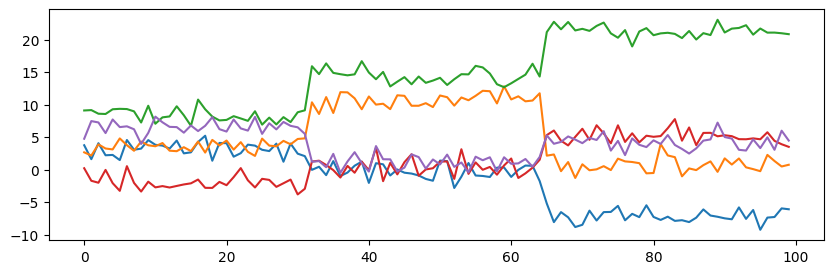

In [260]:
signal, bkps = rpt.pw_constant(n_samples, n_dim, n_bkps, noise_std=noise_std, seed=signal_seed)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
for i in range(n_dim):
    ax.plot(signal[:, i])
plt.show()

### Experiments

#### Basic comparison of the different methods

In [239]:
bic_L2_pen = n_dim/2 * np.log(n_samples)
L2_cost_computor = MyL2Cost()

pen = 2*bic_L2_pen
cps, cost = naive_opt_cpd_dynprog(signal, dummy_L2, pen)
cps2, cost2= precomp_opt_cpd_dynprog(signal, L2_cost_computor, pen)
cps3, cost3 = pelt_cpd(signal, dummy_L2, pen)
# cps4, cost4= pelt_cpd_precomp(signal, 'L2', pen)

In [240]:
print(bic_L2_pen)
print(cps, bkps)
print(cps2, bkps)
print(cps3, bkps)
# print(cps4, bkps)

11.51292546497023
[0, 32, 65] [32, 65, 100]
[0, 32, 65] [32, 65, 100]
[0, 32, 65] [32, 65, 100]


#### Model selection analysis: experiments on the penalty coefficient

In [241]:
print(f"n_samples={n_samples}, n_dim={n_dim}, n_bkps={n_bkps}, std_noise={noise_std} \n")

L2_cost_computor = MyL2Cost()
pen_vals = [0, 0.01, 0.1, 1, 5, 10, 20, 50, 100]
for pen_val in pen_vals:
    # cps, cost = naive_opt_cpd_dynprog(signal, dummy_L2, pen_val)
    # cps, cost = precomp_opt_cpd_dynprog(signal, L2_cost_computor, pen_val)
    cps, cost = pelt_cpd(signal, dummy_L2, pen_val)
    # cps, cost = pelt_cpd_precomp(signal, 'L2', pen_val)
    pev_val_str = str(pen_val) + '   ' 
    print(f"For B={pev_val_str[:4]}: \t bkps = {bkps[:-1]} ;  cps = {cps[1:]}")

n_samples=100, n_dim=5, n_bkps=2, std_noise=1 

For B=0   : 	 bkps = [32, 65] ;  cps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
For B=0.01: 	 bkps = [32, 65] ;  cps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
For B=0.1 : 	 bkps = [32, 65] ;  cps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,

#### Time complexity evaluation

In [11]:
nb_it = 100
total_time_naive = timeit("naive_opt_cpd_dynprog(signal, dummy_L2, pen)", number=nb_it, globals=globals())
total_time_precomp = timeit("precomp_opt_cpd_dynprog(signal, L2_cost_computor, pen)", number=nb_it, globals=globals())
total_time_pelt = timeit("pelt_cpd(signal, dummy_L2, pen)", number=nb_it, globals=globals())
# total_time_pelt_precomp = timeit("pelt_cpd_precomp(signal, 'L2', pen)", number=nb_it, globals=globals())

print(f"Naive method: \t \t \t total time over {nb_it} iterations is {total_time_naive:.2f}s. Average time is {total_time_naive/nb_it:.2f}s")
print(f"With pre-computation: \t \t total time over {nb_it} iterations is {total_time_precomp:.2f}s. Average time is {total_time_precomp/nb_it:.2f}s")
print(f"With PELT : \t \t \t total time over {nb_it} iterations is {total_time_pelt:.2f}s. Average time is {total_time_pelt/nb_it:.2f}s")
# print(f"With PELT and pre-computation: \t total time over {nb_it} iterations is {total_time_pelt_precomp:.2f}s. Average time is {total_time_pelt_precomp/nb_it:.2f}s")

Naive method: 	 	 	 total time over 100 iterations is 7.44s. Average time is 0.07s
With pre-computation: 	 	 total time over 100 iterations is 2.42s. Average time is 0.02s
With PELT : 	 	 	 total time over 100 iterations is 2.59s. Average time is 0.03s


For n_samples=10  : 	 bkps = [] ;  naive_cps = [] ; pre_comp_cps = [] ; PELT = []
For n_samples=50  : 	 bkps = [] ;  naive_cps = [] ; pre_comp_cps = [] ; PELT = []
For n_samples=100 : 	 bkps = [50] ;  naive_cps = [50] ; pre_comp_cps = [50] ; PELT = [50]
For n_samples=200 : 	 bkps = [65, 130] ;  naive_cps = [65, 130] ; pre_comp_cps = [65, 130] ; PELT = [65, 130]
For n_samples=400 : 	 bkps = [79, 156, 242, 320] ;  naive_cps = [79, 156, 242, 320] ; pre_comp_cps = [79, 156, 242, 320] ; PELT = [79, 156, 242, 320]
For n_samples=800 : 	 bkps = [87, 172, 269, 354, 443, 535, 620, 710] ;  naive_cps = [87, 172, 269, 354, 443, 535, 620, 710] ; pre_comp_cps = [87, 172, 269, 354, 443, 535, 620, 710] ; PELT = [87, 172, 269, 354, 443, 535, 620, 710]
For n_samples=1600: 	 bkps = [92, 180, 287, 375, 469, 568, 656, 751, 847, 939, 1037, 1131, 1214, 1324, 1401, 1499] ;  naive_cps = [92, 180, 287, 375, 469, 568, 656, 751, 847, 939, 1037, 1131, 1214, 1324, 1401, 1499] ; pre_comp_cps = [92, 180, 287, 375, 469

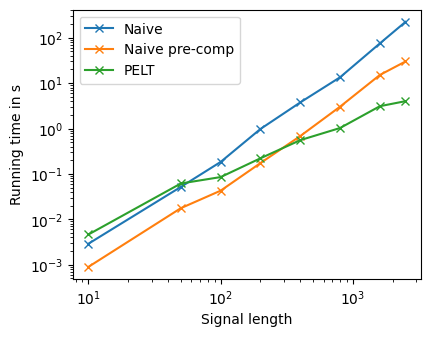

In [ ]:
n_samples_l = [10, 50, 100, 200, 400, 800, 1600, 2500] 
naive_times = []
pre_compt_times = []
pelt_times = []
pelt_precompt_times = []

for n_samples in n_samples_l:
    n_dim = 5
    noise_std = 1
    signal_seed = 2 
    n_bkps = n_samples // 100
    bic_L2_pen = n_dim/2 * np.log(n_samples)
    pen = 2 * bic_L2_pen
    signal, bkps = rpt.pw_constant(n_samples, n_dim, n_bkps, noise_std=noise_std, seed=signal_seed)
    # Naive method
    t1 = time.perf_counter()
    cps_naive, cost = naive_opt_cpd_dynprog(signal, dummy_L2, pen)
    t2 = time.perf_counter()
    naive_times.append(t2 - t1)
    # With pre-computation
    t1 = time.perf_counter()
    cps_pre_comp, cost = precomp_opt_cpd_dynprog(signal, L2_cost_computor, pen)
    t2 = time.perf_counter()
    pre_compt_times.append(t2 - t1)
    # PELT method
    t1 = time.perf_counter()
    cps_pelt, cost = pelt_cpd(signal, dummy_L2, pen)
    t2 = time.perf_counter()
    pelt_times.append(t2 - t1)
    # With pre-computation
    t1 = time.perf_counter()
    # cps_pelt_pre_comp, cost = pelt_cpd_precomp(signal, 'L2', pen)
    # t2 = time.perf_counter()
    # pelt_precompt_times.append(t2 - t1)
    # Checking results
    n_smpl_str = str(n_samples) + '   ' 
    print(f"For n_samples={n_smpl_str[:4]}: \t bkps = {bkps[:-1]} ;  naive_cps = {cps_naive[1:]} ; pre_comp_cps = {cps_pre_comp[1:]} ; PELT = {cps_pelt[1:]}")

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
ax.plot(n_samples_l, naive_times, marker='x', label='Naive')
ax.plot(n_samples_l, pre_compt_times, marker='x', label='Naive pre-comp')
ax.plot(n_samples_l, pelt_times, marker='x', label='PELT')
# ax.plot(n_samples_l, pelt_precompt_times, marker='x', label='PELT pre-comp')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Signal length")
ax.set_ylabel("Running time in s")
ax.legend()
plt.show()

#### Using Ruptures algorithms

In [242]:
def compute_overall_L2cost(signal, bkps, pen):
    """ Returns the overall detection L2 cost for a given signal, 
    given change points and given penalty coefficient.
    For testing purpose only.
    Relies on three different computations.

    Args:
        signal (np.ndarray): signal of shape [n_samples, n_dim]
        bkps (List[int]): time indexes of the change points. 
        pen (float): changing point penaly coefficient.
    return:
        overall_cost (float): the overall change point detection cost
    """
    cost_comp = rpt.costs.CostL2().fit(signal)
    n_samples = signal.shape[0]
    my_overall_cost = -pen
    rpt_overall_cost = -pen
    # Initialization
    if bkps[0] != 0:
        bkps = [0] + bkps
    if bkps[-1] != n_samples:
        bkps = bkps + [n_samples]
    # Cost computation
    for i in range(len(bkps[:-1])):
        my_overall_cost += pen + dummy_L2(signal[bkps[i]:bkps[i+1], :])
        rpt_overall_cost += pen + cost_comp.error(bkps[i], bkps[i+1])
    return my_overall_cost, rpt_overall_cost, cost_comp.sum_of_costs(bkps[1:]) + len(bkps[1:-1])*pen


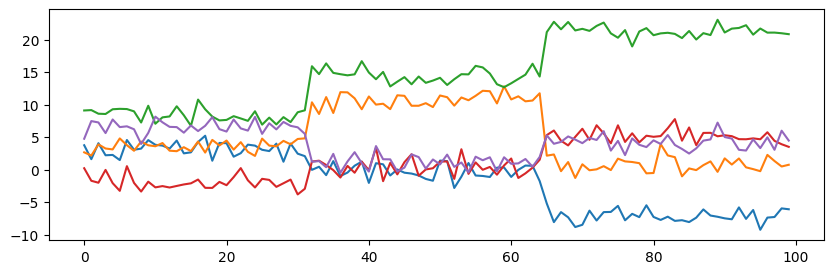

In [243]:
n_samples = 100
n_dim = 5
n_bkps = 2
noise_std = 1
signal_seed = 2

signal, bkps = rpt.pw_constant(n_samples, n_dim, n_bkps, noise_std=noise_std, seed=signal_seed)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
for i in range(n_dim):
    ax.plot(signal[:, i])
plt.show()

In [244]:
bic_L2_pen = n_dim/2 * np.log(n_samples)
pen = 2 * bic_L2_pen

# PELT algorithm from RUPTURES and custom L2 cost
algo_myl2 = rpt.Pelt(custom_cost=MyL2Cost(), jump=1).fit(signal)
rpt_bkps = algo_myl2.predict(pen=pen)

# PELT algorithm from RUPTURES and L2 cost from RUPTURES
algo_rptl2 = rpt.Pelt(model='l2',  jump=1).fit(signal)
rpt_l2rpt_bkps = algo_rptl2.predict(pen=pen)

# custom PELT algorithm and custom L2 cost
pre_comp_bkps, pre_comp_cost = precomp_opt_cpd_dynprog(signal, MyL2Cost(), pen)

# custom PELT algorithm and dummy L2 cost
pelt_bkps, pelt_cost = pelt_cpd(signal, dummy_L2, pen)

print("GROUNDTRUTH: \t \t", bkps, "\t\t ---> cost=", compute_overall_L2cost(signal, bkps, pen))
print("RPT PELT & MyL2: \t", rpt_bkps, "\t ---> cost=", compute_overall_L2cost(signal, rpt_bkps, pen))
print("RPT PELT & RptL2 : \t", rpt_l2rpt_bkps, "\t ---> cost=", compute_overall_L2cost(signal, rpt_l2rpt_bkps, pen))
print("MY precomp & MyL2: \t", pre_comp_bkps, "\t\t ---> cost=", compute_overall_L2cost(signal, pre_comp_bkps, pen))
print("MY PELT & MyL2: \t", pelt_bkps, "\t\t ---> cost=", compute_overall_L2cost(signal, pelt_bkps, pen))

GROUNDTRUTH: 	 	 [32, 65, 100] 		 ---> cost= (546.9816326743044, 546.9816326743044, 546.9816326743044)
RPT PELT & MyL2: 	 [32, 65, 100] 	 ---> cost= (546.9816326743044, 546.9816326743044, 546.9816326743044)
RPT PELT & RptL2 : 	 [32, 65, 100] 	 ---> cost= (546.9816326743044, 546.9816326743044, 546.9816326743044)
MY precomp & MyL2: 	 [0, 32, 65] 		 ---> cost= (546.9816326743044, 546.9816326743044, 546.9816326743044)
MY PELT & MyL2: 	 [0, 32, 65] 		 ---> cost= (546.9816326743044, 546.9816326743044, 546.9816326743044)


In [245]:
print(pre_comp_cost)

546.9816326742854


## GFSS implementation 

In [62]:
import matplotlib
import networkx as nx
from scipy.linalg import eigh

from ruptures.base import BaseCost

### Cost class

In [10]:
class GFSSL2Cost(BaseCost):

    """
    Applies the GFSS rotation to the whole signal before computing
    the standard L2 cost for fixed variance gaussian hypothesis.
    """

    model = "gfss_l2_cost"
    min_size = 1

    def __init__(self, graph, cut_sparsity) -> None:
        self.cut_sparsity = cut_sparsity
        self.graph = graph
        self.signal = None
        self.gft_square_cumsum = None
        self.gft_cumsum = None
        super().__init__()

    def filter(self, freqs, eps=0.00001):
        """Applies the GFSS filter to the input (spatial) frequences.

        Args:
            freqs (np.ndarray): frequences to filter.
            eps (float, optional): threshold for non zero values. Defaults to 0.00001.

        Returns:
            filtered_freqs (np.ndarray): the output of the filter.
        """
        nb_zeros = np.sum(freqs < eps)
        filtered_freqs = np.minimum(1, np.sqrt(self.cut_sparsity / freqs[nb_zeros:]))
        return np.concatenate([np.zeros(nb_zeros), filtered_freqs])
    
    def fit(self, signal):
        """Performs pre-computations for per-segment approximation cost.

        NOTE: the number of dimensions of the signal and their ordering
        must match those of the nodes of the graph.
        The function eigh used below returns the eigenvector corresponding to 
        the ith eigenvalue in the ith column eigvect[:, i]

        Args:
            signal (np.ndarray): of shape [n_samples, n_dim].
        """
        self.signal = signal
        # Computation of the GFSS
        eigvals, eigvects = eigh(nx.laplacian_matrix(self.graph).toarray())
        filter_matrix = np.diag(self.filter(eigvals), k=0)
        gft = filter_matrix.dot(eigvects.T.dot(signal.T)).T
        # Computation of the per-segment cost utils
        self.gft_square_cumsum =  np.concatenate([np.zeros((1, signal.shape[1])), np.cumsum(gft**2, axis=0)], axis=0)
        self.gft_cumsum =  np.concatenate([np.zeros((1, signal.shape[1])), np.cumsum(gft, axis=0)], axis=0)
        return self

    def error(self, start, end):
        """Return the L2 approximation cost on the segment [start:end] 
        where end is excluded, over the filtered signal.

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        if end - start < self.min_size:
            raise ValueError(f'end - start shoud be higher than {self.min_size}')
        
        sub_square_sum = self.gft_square_cumsum[end] - self.gft_square_cumsum[start]
        sub_sum = self.gft_cumsum[end] - self.gft_cumsum[start]
        return np.sum(sub_square_sum - (sub_sum**2) / (end  - start))  
    
    def sum_of_costs(self, bkps):
        """Return the total GFSS cost for the signal and the input break points.

        Args:
            bkps [list[int]]: the list of breaking points.

        Returns:
            float: total cost
        """
        # Initialization
        my_overall_cost = -pen
        n_samples = self.signal.shape[0]
        if bkps[0] != 0:
            bkps = [0] + bkps
        if bkps[-1] != n_samples:
            bkps = bkps + [n_samples]
        # Cost computation
        for i in range(len(bkps[:-1])):
            my_overall_cost += pen + self.error(bkps[i], bkps[i+1])
        return my_overall_cost


### Synthetic data

#### Graph and signal generation

In [65]:
nb_nodes = 30
cluster_nb = 3
mean_cluster_size = 12
inter_density = 0.05
intra_density = 0.85
graph_seed = 10

G = nx.gaussian_random_partition_graph(n=nb_nodes, s=mean_cluster_size, v=2*mean_cluster_size, p_in=intra_density, p_out=inter_density, seed=graph_seed)

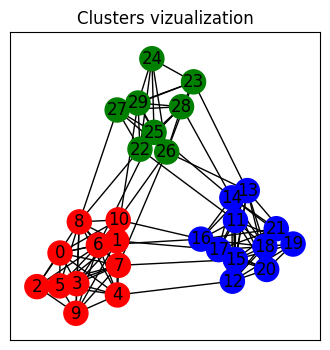

In [66]:
# Vizualization of the graph clusters
#####################################

clusters_seed = 20
clusters = nx.algorithms.community.louvain.louvain_communities(G, seed=clusters_seed)
colors_dct = {0: 'r', 1: 'b', 2: 'g'}
cluster_idx_arr = np.zeros((nb_nodes))

for cl_ind in range(len(clusters)):
    for node_ind in list(clusters[cl_ind]):
        cluster_idx_arr[node_ind] = cl_ind

colors_l = [colors_dct[cluster_idx_arr[node_ind]] for node_ind in range(nb_nodes)]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.set_title('Clusters vizualization')
nx.draw_networkx(G, with_labels=True, node_color=colors_l,  ax=ax)

Text(0.5, 0.98, 'Eigenvectors vizualization')

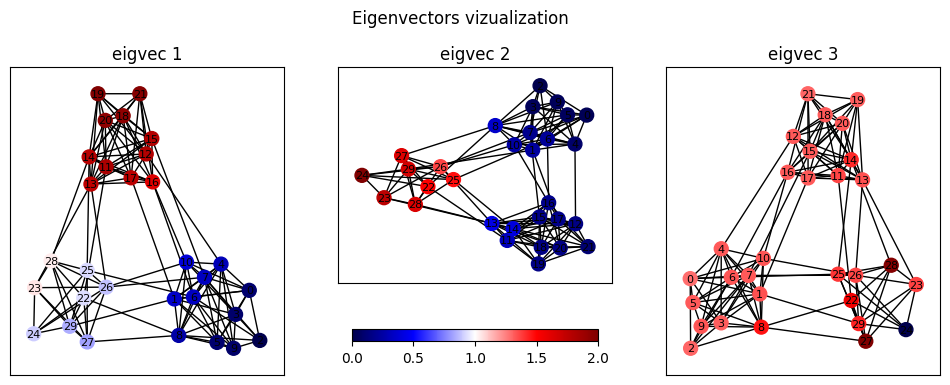

In [68]:
# Vizualization of the eigenvectors shapes
##########################################

###### NOTE:
# The eigh function from scipy stores eigvals and eigvects such that the eigenvector
# corresponding to eigenvalue i (eigval[i]) is the column eigvect[:, i]

import matplotlib

eigvals, eigvects = eigh(nx.laplacian_matrix(G).toarray())
norm = lambda arr: (arr - np.min(arr))/(np.max(arr) - np.min(arr))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
nx.draw_networkx(G, with_labels=True, node_color=norm(eigvects[:, 1]), node_size=100, font_size=8, cmap='seismic', ax=axes[0])
axes[0].set_title(f'eigvec 1')
nx.draw_networkx(G, with_labels=True, node_color=norm(eigvects[:, 2]), node_size=100, font_size=8, cmap='seismic', ax=axes[1])
axes[1].set_title(f'eigvec 2')
nx.draw_networkx(G, with_labels=True, node_color=norm(eigvects[:, 3]), node_size=100, font_size=8, cmap='seismic', ax=axes[2])
axes[2].set_title(f'eigvec 3')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=2), cmap='seismic'), shrink=0.9, ax=axes[1], orientation='horizontal')
fig.suptitle('Eigenvectors vizualization', verticalalignment='bottom')

In [266]:
n_dim_no_change = sum([len(cl) for cl in clusters[:-1]])
n_dim_with_change = len(clusters[-1])
n_dim = n_dim_no_change + n_dim_with_change
n_samples = 100
noise_std = 1
signal_seed = 10

signal_no_change, _ = rpt.pw_constant(n_samples, n_dim_no_change, 0, noise_std=noise_std, seed=signal_seed)
signal_with_change, bkps = rpt.pw_constant(n_samples, n_dim_with_change, 1, noise_std=noise_std, seed=signal_seed)
signal = np.concatenate([signal_no_change, signal_with_change], axis=1)

#### Experiments

In [267]:
bic_L2_pen = n_dim/2 * np.log(n_samples)
pen = 2* bic_L2_pen

#  WITHOUT GRAPH STRUCTURE
algo = rpt.Pelt(model='l2', jump=1).fit(signal)
my_bkps = algo.predict(pen=pen)
print("WITHOUT GRAPH: ", bkps, my_bkps)

#  WITH GRAPH STRUCTURE
graph_algo = rpt.Pelt(custom_cost=GFSSL2Cost(G, 2), jump=1).fit(signal)
my_graph_bkps = graph_algo.predict(pen=pen)
print("WITH GRAPH: ", bkps, my_graph_bkps)

WITHOUT GRAPH:  [49, 100] [49, 100]
WITH GRAPH:  [49, 100] [49, 100]


In [268]:
noise_std_values = [0.1, 1, 2, 3, 4]

n_dim_no_change = sum([len(cl) for cl in clusters[:-1]])
n_dim_with_change = len(clusters[-1])
n_dim = n_dim_no_change + n_dim_with_change
n_samples = 100
signal_seed = 10

bic_L2_pen = n_dim/2 * np.log(n_samples)
pen = 2* bic_L2_pen

for noise_std in noise_std_values:
    
    signal_no_change, _ = rpt.pw_constant(n_samples, n_dim_no_change, 0, noise_std=noise_std, seed=signal_seed)
    signal_with_change, gt_bkps = rpt.pw_constant(n_samples, n_dim_with_change, 1, noise_std=noise_std, seed=signal_seed)
    signal = np.concatenate([signal_no_change, signal_with_change], axis=1)

    # WITH DYN PROG WITHOUT PELT AND WITH GRAPH
    cost_dyn_prod = GFSSL2Cost(G, 1)
    pre_comp_bkps, pre_comp_cost = precomp_opt_cpd_dynprog(signal, cost_dyn_prod, pen)

    # WITH GRAPH STRUCTURE
    cost_rpt_pelt = GFSSL2Cost(G, 1)
    graph_algo = rpt.Pelt(custom_cost=cost_rpt_pelt, jump=1).fit(signal)
    my_graph_bkps = graph_algo.predict(pen=pen)

    # WITHOUT GRAPH STRUCTURE
    algo = rpt.Pelt(model='l2', jump=1).fit(signal)
    my_bkps = algo.predict(pen=pen)
    
    print("NOISE_STD=", noise_std, "\tGROUNDTRUTH", bkps, "\tPRE-COMP WITH GRAPH:", pre_comp_bkps, "\tWITH GRAPH: ", my_graph_bkps, "\tWITHOUT GRAPH: ",  my_bkps)

    print(pre_comp_cost, cost_dyn_prod.sum_of_costs(pre_comp_bkps), cost_rpt_pelt.sum_of_costs(my_graph_bkps))


NOISE_STD= 0.1 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH: [0, 49] 	WITH GRAPH:  [49, 100] 	WITHOUT GRAPH:  [49, 100]
142.46864210178802 142.46864210178802 142.46864210178802
NOISE_STD= 1 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH: [0, 49] 	WITH GRAPH:  [49, 100] 	WITHOUT GRAPH:  [49, 100]
569.5087577943228 569.5087577943228 569.5087577943228
NOISE_STD= 2 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH: [0, 49] 	WITH GRAPH:  [49, 100] 	WITHOUT GRAPH:  [4, 7, 17, 21, 30, 32, 37, 40, 44, 49, 51, 54, 57, 88, 91, 96, 98, 100]
1863.5697144383537 1863.5697144383535 1863.5697144383535
NOISE_STD= 3 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH: [0, 49] 	WITH GRAPH:  [49, 100] 	WITHOUT GRAPH:  [3, 5, 7, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
4020.3379755117494 4020.3379755117494 4020.3379755117494
NOISE_STD= 4 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH: [0, 

In [269]:
cost_rpt_pelt.sum_of_costs([49, 50])

7124.8989805473975

### Real data

The dataset we use in the following part is the [Wind Spatio-Temporal Dataset2](https://zenodo.org/records/5516550). We extract the values corresponding to the wind speed and the power for the 200 turbines. Such values are the considered multivariate time series. We also use the coordinates of the turbines to turn our time signals into a grap time series.

In [108]:
from math import asin, cos, radians, sin, sqrt
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

#### Building the graph

In [109]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    From https://github.com/deepcharles/tutorials-mva-2023-2024/blob/main/session%203/06_GraphSignal.ipynb 

    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    WARNING: Points must be in the format (LONGITUDE, LATITUDE)
    -------- 

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [110]:
def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    """Applies the exponential similarity formula
    to turn a distance matrix into an adjacency matrix.
    """
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [111]:
coord_df = pd.read_csv('data/turbines_coord.csv', index_col=0)
coord_df.head(2)

,Turbine1,Turbine2,Turbine3,Turbine4,Turbine5,Turbine6,Turbine7,Turbine8,Turbine9,Turbine10,...,Turbine191,Turbine192,Turbine193,Turbine194,Turbine195,Turbine196,Turbine197,Turbine198,Turbine199,Turbine200
Latitude,40.477244,40.475753,40.482172,40.476083,40.477691,40.476644,40.468356,40.467822,40.469174,40.469943,...,40.465623,40.466515,40.476735,40.484373,40.478015,40.480521,40.481436,40.474048,40.476706,40.468869
Longitude,-88.798072,-88.795484,-88.779434,-88.779391,-88.772025,-88.767455,-88.771024,-88.767047,-88.762329,-88.758539,...,-88.509904,-88.504403,-88.506786,-88.506575,-88.503654,-88.494055,-88.487407,-88.490050,-88.482632,-88.491678


In [112]:
# Construction of the distance matrix of the turbines, with condensed and full view
coord_np = coord_df.T.to_numpy()[:, ::-1]
dist_mat_condensed = pdist(coord_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

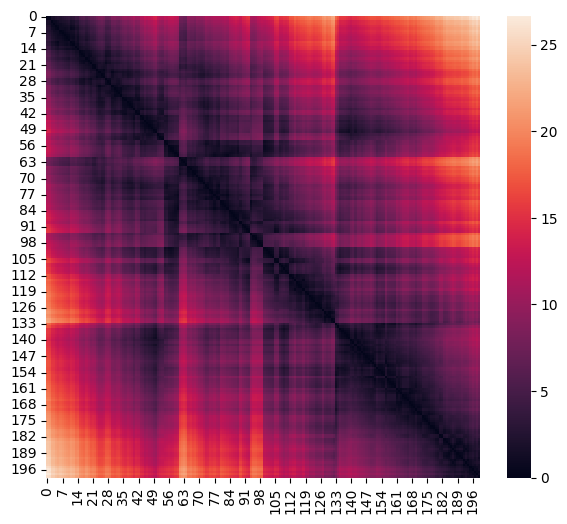

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
_ = sns.heatmap(dist_mat_square, ax=ax,)

In [114]:
# Store the coordinates in a dictionnary to improve graph rendering
coord_dict = coord_df.to_dict()
coord_dict_formatted = {int(key[7:])-1: (val['Longitude'], val['Latitude']) for key, val in coord_dict.items()}
# COmputation of the rendering ratio based on real longitude/latitude ranges ratio
max_val = np.max(coord_np, axis=0)
min_val = np.min(coord_np, axis=0)
rendering_ratio = 1/np.abs( (max_val[1] - min_val[1]) / (max_val[0] - min_val[0]) )

In [115]:
# Construction of the graph based on the distance matrix
DIST_THRESHOLD = 2
adjacency_matrix = squareform((dist_mat_condensed < DIST_THRESHOLD).astype(int))
G = nx.Graph(adjacency_matrix)
print(f"The graph is {'not ' if not nx.is_connected(G) else ''}connected, with {G.order()} nodes, {G.size()} edges")

The graph is connected, with 200 nodes, 1331 edges


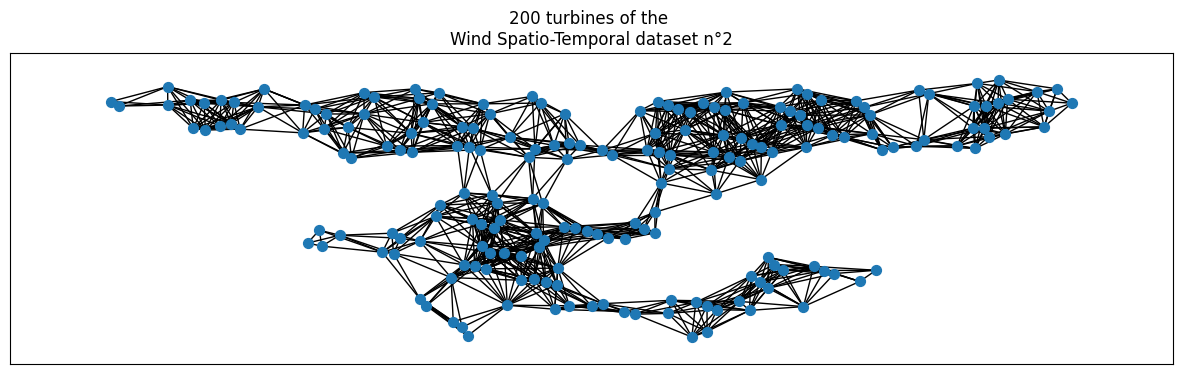

In [116]:
length = 15
fig, ax = plt.subplots(1, 1, figsize=(length, length/rendering_ratio))
ax.set_title('200 turbines of the \nWind Spatio-Temporal dataset n°2')
nx.draw_networkx(G, with_labels=False,  ax=ax, node_size=50, width=1, pos=coord_dict_formatted)

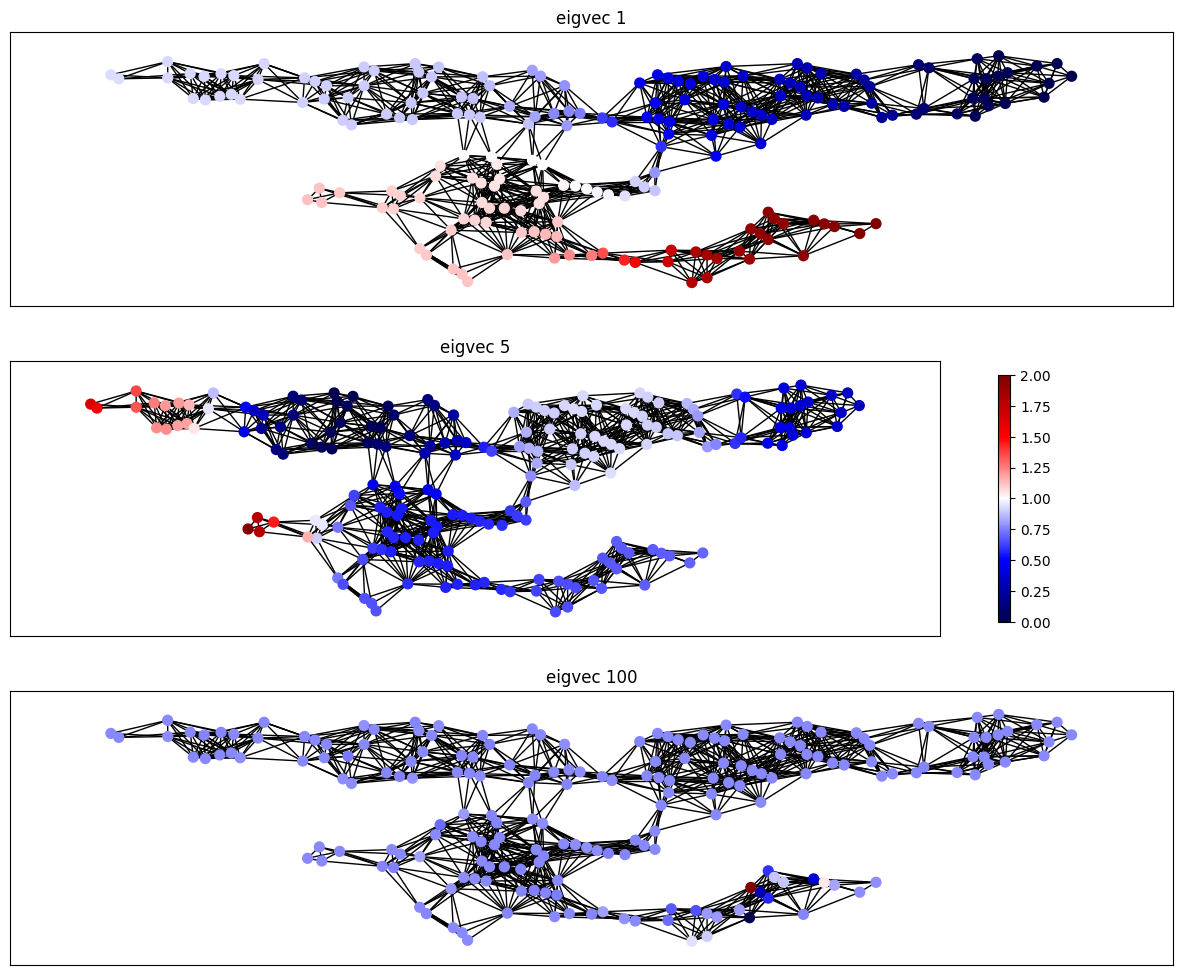

In [127]:
eigvals_idx = [1, 5, 100]

eigvals, eigvects = eigh(nx.laplacian_matrix(G).toarray())
norm = lambda arr: (arr - np.min(arr))/(np.max(arr) - np.min(arr))

fig, axes = plt.subplots(3, 1, figsize=(length, 3*length/rendering_ratio))
nx.draw_networkx(G, with_labels=False, node_color=np.round(eigvects[:, eigvals_idx[0]], decimals=6), node_size=50, width=1, pos=coord_dict_formatted, cmap='seismic', ax=axes[0])
axes[0].set_title(f'eigvec {eigvals_idx[0]}')
nx.draw_networkx(G, with_labels=False, node_color=eigvects[:, eigvals_idx[1]], node_size=50, width=1, pos=coord_dict_formatted, cmap='seismic', ax=axes[1])
axes[1].set_title(f'eigvec {eigvals_idx[1]}')
nx.draw_networkx(G, with_labels=False, node_color=eigvects[:, eigvals_idx[2]], node_size=50, width=1, pos=coord_dict_formatted, cmap='seismic', ax=axes[2])
axes[2].set_title(f'eigvec {eigvals_idx[2]}')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=2), cmap='seismic'), shrink=0.9, ax=axes[1], orientation='vertical')
# fig.suptitle('Eigenvectors vizualization', verticalalignment='bottom')

#### Applying CPD to the graph signal

In [122]:
speed_power_df = pd.read_csv('data/turbines_speed_power.csv', index_col=0)
speed_power_df.head(2)

# Extracting only the wind speed data
speed_col_names = ['Time'] + [col_name for col_name in speed_power_df.columns if 'Speed' in col_name]
speed_df = speed_power_df[speed_col_names].copy(deep=True)
speed_df['Time'] = pd.to_datetime(speed_df['Time'], format='mixed')

In [123]:
# Extraction a subset of the rows based on date
date_lim = '2010-10-01'
speed_np = speed_df[speed_df.Time <= date_lim].to_numpy()[:, 1:]

In [126]:
n_samples, n_dim = speed_np.shape
bic_L2_pen = n_dim/2 * np.log(n_samples)
pen = 2* bic_L2_pen

#  WITHOUT GRAPH STRUCTURE
algo = rpt.Pelt(model='l2', jump=1).fit(speed_np)
my_bkps = algo.predict(pen=pen)
print("WITHOUT GRAPH: ", my_bkps)

#  WITH GRAPH STRUCTURE
graph_algo = rpt.Pelt(custom_cost=GFSSL2Cost(G, 1), jump=1).fit(speed_np)
my_graph_bkps = graph_algo.predict(pen=pen)
print("WITH GRAPH: ", my_graph_bkps)

WITHOUT GRAPH:  [12, 15, 35, 52, 54, 65, 72, 76, 96, 101, 108, 115, 134, 140, 144, 154, 160, 168, 172, 177, 181, 185, 197, 206, 218, 232, 246, 248, 256, 260, 272, 278, 281, 290, 299, 305, 327, 337, 339, 350, 365, 381, 388, 394, 406, 409, 415, 422, 425, 427, 432, 434, 439, 442, 449, 457, 460, 478, 481, 494, 497, 503, 507, 510, 514, 528, 530, 544, 565, 570, 584, 590, 598, 602, 604, 617, 632, 638, 675, 679, 682, 686, 705, 721]
WITH GRAPH:  [721]


## DRAFT

In [49]:
# def pelt_cpd_precomp(signal, cost_computor, pen_val):
#     ''' 
#     The PELT algorithm described in 'Optimal Detection
#     of Changepoints With a Linear Computational Cost, R. Killick'.
#     Computation tricks are leveraged to (pre-)compute the approximation costs per 
#     segment of the input signal.

#     args:
#         signal: (np.ndarray) of shape [n_samples, n_dim]
#         pen_val: (float) penalty coefficient
#         cost_computor: (BaseCost)

#     return:
#         cps_per_t[-1]: (List[int]) change points detected
#         tot_costs[-1]: (float) associated overall cost
#     '''
#     # Initialization
#     n_samples = signal.shape[0]
#     tot_costs = -pen_val * np.ones(n_samples+1)
#     cps_per_t = [[]]
#     optim_set = [0]
#     # Pre-computation of the cost per segment
#     cost_computor.fit(signal)
#     # Dynamic programmation CPD
#     for t in range(1, n_samples+1):
#         running_per_segment_cost = np.array([cost_computor.error(s, t) for s in range(t)])
#         possible_running_costs =  tot_costs[:t] + running_per_segment_cost + pen_val
#         running_indexes = np.arange(t)
#         cp_ind = np.argmin(possible_running_costs[np.array(optim_set)])
#         cp = running_indexes[np.array(optim_set)][cp_ind]
#         tot_costs[t] = possible_running_costs[cp]
#         cps_per_t.append(cps_per_t[cp] + [cp])
#         optim_set = [s for s in optim_set if (tot_costs[s] + running_per_segment_cost[s]) <= tot_costs[t]] + [t]
#     return cps_per_t[-1], tot_costs[-1]